In [1]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
# with open('data/text_data/anna.txt', 'r') as f:

    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

# Looking at the X, y
X.shape, y.shape, X[:10], y[:10]

((3629,),
 (3629,),
 array([64, 17, 10, 17, 42, 66, 63, 64, 17, 10]),
 array([17, 10, 17, 42, 66, 63, 64, 17, 10, 17]))

In [2]:
# Model or Network
import impl.layer as l

class GRU:
    def __init__(self, D, H, L, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.), 
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []
        for layer in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wh, Wy = m['Wz'], m['Wh'], m['Wy']
        bz, bh, by = m['bz'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        # h = ((1. - hz) * h_in) + (hz * hh)
        # or
        h = h_in + (hz * (hh - h_in))

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        
        dhh = hz * dh
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        # dhz = (hh * dh) - (h_in * dh)
        # or
        dhz = (hh - h_in) * dh
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXh + dXz
        dh_in2 = dX[:, :self.H]
        dX_in = dX[:, self.H:]

        dh = dh_in1 + dh_in2
        dX = dX_in

        grad = dict(Wz=dWz, Wh=dWh, Wy=dWy, bz=dbz, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])

        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
        
        dXs = []
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dy = dX.copy()
            dXs.append(dX)
                
        return dXs, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer])
                X = y.copy()
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [3]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    #for i in range(0, X.shape[0], minibatch_size):
    for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):

    M, R = [], []
    for layer in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    eps = 1e-8
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for layer in range(nn.L):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)

                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))

                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, 100)
            print(sample)

    return nn

Iter-1 loss: 240.1729
 Aisis thi an the In rnd She rivind Sounns in the Noat ttorears ines the the cht an ancaxmeinakebte c
Iter-2 loss: 210.8772
 Japand-lapth pothe rao thi Sodas an he porcecisist-e WeseunT's 1–65t in the Giuperbb finst of the. c
Iter-3 loss: 195.4141
 Ase EangTis mioke itumilebin an tivoper, and Che poontry 2iisl ionten  my teilaseny mbemkecoulJab of
Iter-4 loss: 190.2851
 purto hion aCNrymwith-rypernt loke, al cynitury prhalaro-5li)wein einby aldKtly in whe ny 1:Abtrerin
Iter-5 loss: 181.9995
 in atpinaken mipero lauling an k bestoby teunily in the aunrt% inmes ilmbere 124u, country )ind Japa
Iter-6 loss: 182.0812
 120Stakientidi ap popembirget lodentimeand inden wige ton, the worl wire 2NlPores eupont. Abeam inte
Iter-7 loss: 182.8767
 in tha  mebentreacenopker, the Jainty hy world, and Aowal Ciiand a dentirt the ulet it in expanest T
Iter-8 loss: 178.6607
 Gt0at romest inss rensed chasenearly l2in 194y pimitatrepenterost. of the nuth cing s merlion mina. 
Iter-9 l

Iter-67 loss: 50.8712
 solctaed condinila. Japan is ranked :ounthy ,ivlien fornal ounstevecllestercotal power 3faingan is o
Iter-68 loss: 53.7354
 live of enchalesed chacaneres ofte gonality an in 1941, which came to an ender. IJapan is and marced
Iter-69 loss: 56.2431
 world's toran suded Japan to expand its embith un lares fimpin molacmionthing militarism. Therocty p
Iter-70 loss: 53.1254
 Searopumiding stutal Earth-largest icmberessa marieg duved Japan to ax ind in militar In, rthwind it
Iter-71 loss: 48.3629
 percalita, ated folettire tory onle million eivered conseited The fourth-largest importer. Althougha
Iter-72 loss: 48.5299
 and Nagasare. country of 126 alllesimero fed As abud hal puraldy of Horntiry caparese gho the eort c
Iter-73 loss: 47.6521
 and any mbar as horol histore cas in the Counary wide in the Global Competitiveness Report 2015–2016
Iter-74 loss: 47.7017
 -ralasered strrored it lares ai hicoped and early al abcodilldirl thirnt e pantiot limetital pivila 
Iter-75 

Iter-133 loss: 29.6417
 Asian country in the Global Peace Index. Japan was the first country in Asia coleciding profec in th
Iter-134 loss: 29.2124
 and is ofthogh seacobyl cons inlald canseu ats in 1s4 , vilater Toklarese foured ligaser and china S
Iter-135 loss: 29.4673
 Noparmy. Archaeological resedrchmior hige Eurch tatif the nom targest military budget, used for self
Iter-136 loss: 29.1865
 forutanity profor alan is and the nation. In the late 19th and early 20th centurioun omiWas faclares
Iter-137 loss: 26.9876
 of Nihenel. 日本 as the decfen inghas the world, and ranked firth inst conomira. The country is divide
Iter-138 loss: 28.7134
 which was ended in 185 allegin", and a plete the G8, and the G20 and its opermed inforban sunceliont
Iter-139 loss: 26.8561
 ghosthe alop canesy asth as the Upper Paleolithic pemindard coJapan's laDe Acons. The country is div
Iter-140 loss: 27.2212
 as a moral me ingitrdivined file ty an lobe popun io alembont or 68,inate piroladint power paritd of


Iter-199 loss: 16.0899
 and is ofthive iomat mainacital city of Japan, which iscanal colyoving a perod pofur and followad, t
Iter-200 loss: 17.0374
 47 prefecturu, in lart popul mile of Japan is a dectare forst word co promed and of lojos a derized 
Iter-201 loss: 16.3430
 Japan tas peacenited in the number as the world's impreadan in 1945 following the atomic bombings of
Iter-202 loss: 17.5623
 pexpar, it maincandec on exth the wot da, haleof Japan, the hasihe flord constriem.d reaser arllowed
Iter-203 loss: 15.8786
 in the world, and ranked first in the number of Nobel laureates of any country in Asia. Japan is ran
Iter-204 loss: 16.7669
 withir the world's fimst to the East China Sea and Taiwan in the sorth lowed boundiceane Sino a ind 
Iter-205 loss: 15.6492
 Empire of Japan was proclaimed fomat to asch at of lakese anop and the Glcateal military with the wo
Iter-206 loss: 16.1967
 warly 20 in enghict and Russoped the world's fourth-largest exporter and fourth-largest importer. Al


Iter-265 loss: 12.0863
 the Upper Paleolithic period. The first written mention of Japan is ranked first in the Country Bran
Iter-266 loss: 12.1934
 the name of the Emperor. Japan entered into a long period of isolation in the early 17th century, wh
Iter-267 loss: 12.1852
 the world, in the caperat power. The UN,htht hasunh the world's third-largest economy by nominal GDP
Iter-268 loss: 12.1473
 Sino-Japanese War, the Russo-Japanese War and World War I allowed Japan to expand its empire during 
Iter-269 loss: 12.2875
 the world, and ranked first in the number of Nobel laureates of any country in Asia. Japan is ranked
Iter-270 loss: 12.0196
 the highest life expectunceIndkoiome in Chinest -stad conctituliarch modic bar, to the world's fourt
Iter-271 loss: 12.0701
 military budget, used for self-defense and peacekeeping rolesl an allower. ap realionturies, victori
Iter-272 loss: 11.8217
 Index whose population enjoys the highest life expectancy, the third lowest infant mortality in the 


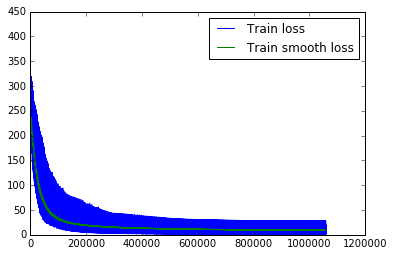

In [5]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 300 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

Iter-1 loss: 224.1500
 miean Wx peanv, Japan CDorthi rith G9mR8ex ond burthe Norof Aipckrinn TnRtsr ripthaPs Gumi, Ro por2 
Iter-2 loss: 204.5220
 coler- lanla yinh chCovexinryark mse wargSunaHd pouaseg ofghethish Gopins andLWs Dexties 90o hi Dovi
Iter-3 loss: 198.6107
 loulaas, the EopsHanth CE's tith the tere ink ine GxAst Glopan Sis, in makry 17, t"ec. Fans checkorl
Iter-4 loss: 183.1245
 8plitered th the Empurtro and A jokeo1f in ean-Honsie OHuns re unfre tarAry wor the fpurt realles th
Iter-5 loss: 175.8622
 haunst Japan wist and Japan, the hist anokeeg, st vopond ry wigh hich wokbl-nofh the Umport cCfertt 
Iter-6 loss: 173.0827
 and of NheRwist rgg ol ziotly with in th- ancexth renoy, Is chilant in the  furth. Tde worstand 9nt 
Iter-7 loss: 174.0925
 miotioncury cosst to islled ts the alopexArsi. Japanas eJpeconala tsest resturyy, whund -Japan es ce
Iter-8 loss: 163.1981
 and Hushaskallofed Sencecternd Wrats imll wrost CIwbont pendivanes. Japanest ralicy forntalced and t
Iter-9 l

Iter-67 loss: 47.7948
 Tokyo and at the serol to of Japane eass a dixth largest military budget, used for seates of interca
Iter-68 loss: 47.9095
 and the world's eighth largest military budget, used fol the Gy, expanchestk muntiry wan Emperor an 
Iter-69 loss: 46.1993
 alest revisoly wan the anded it restre. Dhe up with the Sino, a lorter. Wist rifoliol touthith reake
Iter-70 loss: 46.0350
 propeclin to of 6,852 is and inse nmmel wornalivingist anden the First in the Chunthe G wate in thi 
Iter-71 loss: 44.7931
 and the world's anoresl-Japanese Ware divine a mbextorgest imperim mainly Imperial Cohogh an Emperor
Iter-72 loss: 44.2393
 of cohed Jangr histolited inte in the natioun" and Huthi-d kue,, which came ty in the world, and ran
Iter-73 loss: 43.7388
 popelation op Japan is in oun", and the world's fourth. From the Sea of Okhotsk in the north to the 
Iter-74 loss: 42.6085
 al eletted frletertest imperte cantudisene as Japan has officiacloded eturititat of the Firsh tho wa
Iter-75 

Iter-133 loss: 22.2624
 is largest military budget, used for self-defense and peacekeeping roles. Japan is a developed const
Iter-134 loss: 21.4611
 arokkoun in Chine im the catetityo Nopecand a dien, Sthoca Sin1a a lowed popor the GD und the Eupari
Iter-135 loss: 22.1553
 fourth-largest ixpopiecge tordesty sixth in the Globed Stata and the world's eyurth largest ixpopina
Iter-136 loss: 21.0332
 fourter and fourth-largest importer. Although Japan has officially renounced its right to declare wa
Iter-137 loss: 21.6521
 and the G20ta an Emperor and an elected legislature thilalion in the Courthildet the Global Competit
Iter-138 loss: 20.7309
 as a strat of increasing powar, It il the obing bolttolited cited a untein ladee fourth-largest expo
Iter-139 loss: 21.0231
 foresland mounded in, is and errom inhec aregionsr a olntury CEnfike porld in 1868 borldand in isola
Iter-140 loss: 20.5507
 war 1945 Infeealled the highest million meotent in the number of the UN, the G7, the G8, and the G20


Iter-199 loss: 13.2162
 the world's eighth largest military budget, used for self-defenal cinttion in the First wint enpan e
Iter-200 loss: 13.2400
 arowikat power. The country hasth to the East China Sea and Taiwan in the south. The kanji that make


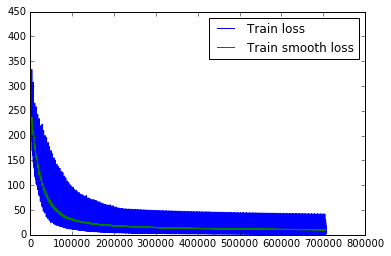

In [4]:
# # Hyper-parameters
# time_step = 100 # width, minibatch size and test sample size as well
# num_layers = 1 # depth
# n_iter = 200 # epochs
# alpha = 1e-4 # learning_rate
# print_after = 1 # n_iter//10 # print training loss, valid, and test
# num_hidden_units = 64 # num_hidden_units in hidden layer
# num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# # Build the network and learning it or optimizing it using SGD
# net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# # Start learning using BP-SGD-ADAM
# adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()